# Phase 4: Machine Learning Models

XGBoost, LightGBM, Random Forest with time-series cross-validation.

In [2]:
# Install ML dependencies if missing (run this cell once)
import subprocess
import sys
for pkg in ("xgboost", "lightgbm"):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 3.4 MB/s eta 0:00:00a 0:00:01



[notice] A new release of pip is available: 25.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.data_loader import REPO_ROOT, load_and_merge_data, load_raw_tables
from src.feature_engineering import build_ml_features
from src.models.ml_models import (
    get_time_series_cv,
    fit_xgboost,
    fit_lightgbm,
    fit_random_forest,
)
from src.metrics import mae, evaluate_forecasts

## 1. Prepare Data

In [4]:
data_dir = REPO_ROOT / "data" / "store-sales-time-series-forecasting"
df = load_and_merge_data(data_dir)
tables = load_raw_tables(data_dir)

# Aggregate to daily level
daily = df.groupby('date').agg({
    'sales': 'sum',
    'onpromotion': 'sum',
    'is_holiday': 'first',
}).reset_index()
daily['is_holiday'] = daily['is_holiday'].fillna(False).astype(int)

# Build features
feat_df = build_ml_features(daily, lags=[1, 7, 14, 30], rolling_windows=[7, 14, 30])
feat_df = feat_df.dropna().reset_index(drop=True)

feature_cols = [c for c in feat_df.columns if c not in ['date', 'sales']]
print('Features:', feature_cols)

Features: ['onpromotion', 'is_holiday', 'day_of_week', 'month', 'year', 'is_weekend', 'promotion_flag', 'lag_1', 'lag_7', 'lag_14', 'lag_30', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_30']


## 2. Time-Series Split

In [5]:
X = feat_df[feature_cols].values
y = feat_df['sales'].values

train_end_idx = int(len(feat_df) * 0.85)
X_train, X_val = X[:train_end_idx], X[train_end_idx:]
y_train, y_val = y[:train_end_idx], y[train_end_idx:]

print(f'Train: {len(X_train)}, Val: {len(X_val)}')

Train: 1405, Val: 249


## 3. Train Models

In [6]:
xgb_model = fit_xgboost(X_train, y_train, X_val, y_val)
lgb_model = fit_lightgbm(X_train, y_train, X_val, y_val)
rf_model = fit_random_forest(X_train, y_train)

y_xgb = xgb_model.predict(X_val)
y_lgb = lgb_model.predict(X_val)
y_rf = rf_model.predict(X_val)

## 4. Metrics

In [7]:
results = {
    'XGBoost': evaluate_forecasts(y_val, y_xgb),
    'LightGBM': evaluate_forecasts(y_val, y_lgb),
    'RandomForest': evaluate_forecasts(y_val, y_rf),
}
pd.DataFrame(results).round(2)

,XGBoost,LightGBM,RandomForest
MAE,76533.49,73819.16,81963.65
RMSE,122692.17,118588.34,135501.91
MAPE,33.74,36.97,44.79


## 5. Feature Importance

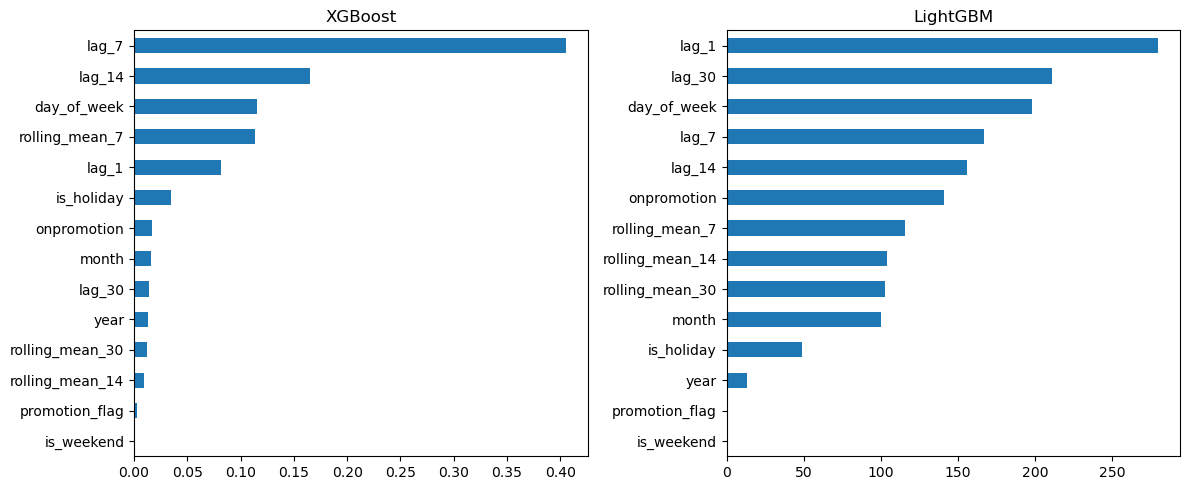

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

imp_xgb = pd.Series(xgb_model.feature_importances_, index=feature_cols).sort_values(ascending=True)
imp_xgb.plot(kind='barh', ax=axes[0], title='XGBoost')

imp_lgb = pd.Series(lgb_model.feature_importances_, index=feature_cols).sort_values(ascending=True)
imp_lgb.plot(kind='barh', ax=axes[1], title='LightGBM')

plt.tight_layout()
plt.show()

## 6. Actual vs Predicted

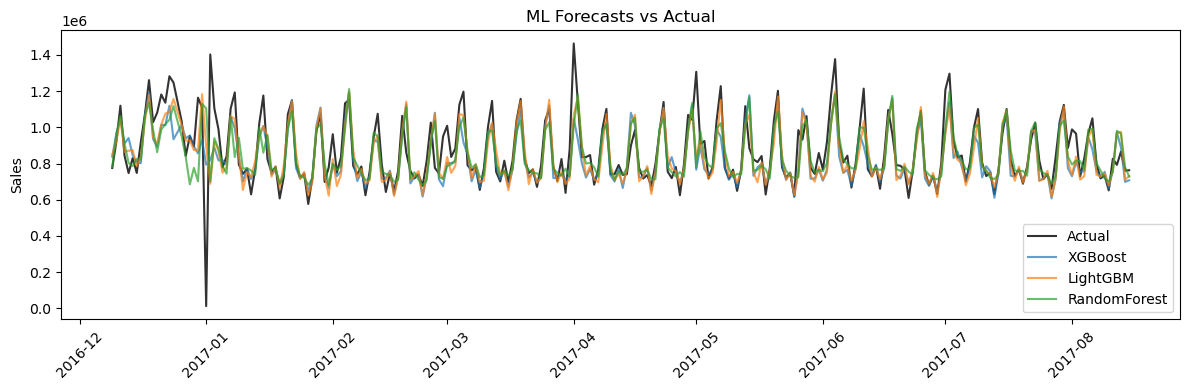

In [9]:
val_dates = feat_df.loc[train_end_idx:, 'date']
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(val_dates.values, y_val, label='Actual', color='black', alpha=0.8)
ax.plot(val_dates.values, y_xgb, label='XGBoost', alpha=0.7)
ax.plot(val_dates.values, y_lgb, label='LightGBM', alpha=0.7)
ax.plot(val_dates.values, y_rf, label='RandomForest', alpha=0.7)
ax.legend()
ax.set_title('ML Forecasts vs Actual')
ax.set_ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()